In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import RandomOverSampler

from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('../data/reviews_with_ratings_cleaned.csv', index_col = 'Unnamed: 0', keep_default_na = False)
df.sample(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments,avg_rating,avg_score_below_4,avg_score_below_5th_percentile,comments_clean
250665,48425132,603625416757344607,2022-04-12,446028569,Sara,Great location near GWU. It is a 7 min walk to...,4.691429,0,0,great location near gwu it is a 7 min walk to ...
320652,1002901371177254584,1078314860855783249,2024-01-27,7022298,Amy,They were super friendly hosts and I could not...,4.834286,0,0,they were super friendly hosts and i could not...
185619,30378859,423799689525006949,2021-08-07,207600504,Saar,Great host and fabulous communication. We had...,4.954286,0,0,great host and fabulous communication we had a...
294960,639293163754818325,1031910200869545826,2023-11-24,507877132,Michal,Super clean and private aparment.<br/>Fully eq...,4.957143,0,0,super clean and private aparment br fully equi...
278011,53645937,1003635660521703289,2023-10-16,235644649,Leon,We enjoyed it well enough to seek out other So...,4.637143,0,0,we enjoyed it well enough to seek out other so...


In [3]:
df.isnull().sum()

listing_id                        0
id                                0
date                              0
reviewer_id                       0
reviewer_name                     0
comments                          0
avg_rating                        0
avg_score_below_4                 0
avg_score_below_5th_percentile    0
comments_clean                    0
dtype: int64

In [4]:
print(df['avg_score_below_5th_percentile'].value_counts()),
print('*'*30)
df['avg_score_below_5th_percentile'].value_counts(normalize = True)

avg_score_below_5th_percentile
0    320774
1      2033
Name: count, dtype: int64
******************************


avg_score_below_5th_percentile
0    0.993702
1    0.006298
Name: proportion, dtype: float64

In [5]:
X = df[['comments_clean']] # Had to make it double square brackets to make it a 2D array
X.shape

(322807, 1)

In [6]:
y = df['avg_score_below_5th_percentile']
y.shape

(322807,)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242105, 1), (80702, 1), (242105,), (80702,))

#### Oversampling the minority class

In [9]:
ros = RandomOverSampler(random_state = 42) # Added a random state to the oversampler for replicability

In [10]:
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

In [11]:
X_train_over.shape, y_train_over.shape, X_test.shape, y_test.shape

((481160, 1), (481160,), (80702, 1), (80702,))

In [27]:
y_train.value_counts(), y_train_over.value_counts(), y_test.value_counts()

(avg_score_below_5th_percentile
 0    240580
 1      1525
 Name: count, dtype: int64,
 avg_score_below_5th_percentile
 0    240580
 1    240580
 Name: count, dtype: int64,
 avg_score_below_5th_percentile
 0    80194
 1      508
 Name: count, dtype: int64)

#### Will try adding stop words

In [21]:
stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

#### Added Jasmine since Jasmine has a few poor reviews so it's learning about her

#### Also added some negative phrases. My goal isn't to learn that negative words predict negative ratings - I want to understand the specifics of WHY someone had a bad/poor/terrible experience

In [23]:
new_stop_words = ['jasmine', 'poor', 'bad', 'terrible', 'worst', 'didn', 'wasn']
stop_words.append(new_stop_words)

In [24]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
added_stop_words = stop_words

In [25]:
pipe = Pipeline([
    ('tf', TfidfVectorizer() ),
    ('logr', LogisticRegression(class_weight = 'balanced') )
])

In [28]:
pipe_params = {
    'tf__stop_words' : ['english', 'added_stop_words'], # Added the new stop words into the model
    'tf__max_features' : [5_000, 10_000, 30_000],
    'tf__min_df' : [150, 300],  # Increase the minimum on the DF since I'm oversampling the minority class by a factor of 157
    'tf__ngram_range': [ (1,1), (1,2), (1,3) ]
}

In [29]:
gs = GridSearchCV(pipe, pipe_params, n_jobs = -1, verbose = 10)

In [30]:
gs.fit(X_train_over['comments_clean'], y_train_over)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\david\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transf

GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'tf__max_features': [5000, 10000, 30000],
                         'tf__min_df': [150, 300],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tf__stop_words': ['english', 'added_stop_words']},
             verbose=10)

#### Best Params: Max Features of 30k, Min_df of 150, n_gram range: 1,3, stop_words: english

In [31]:
gs.best_params_

{'tf__max_features': 30000,
 'tf__min_df': 150,
 'tf__ngram_range': (1, 3),
 'tf__stop_words': 'english'}

In [33]:
gs.best_score_

0.9617216726244908

In [34]:
gs.score(X_train_over['comments_clean'], y_train_over), gs.score(X_test['comments_clean'], y_test)

(0.972753346080306, 0.9424797402790513)

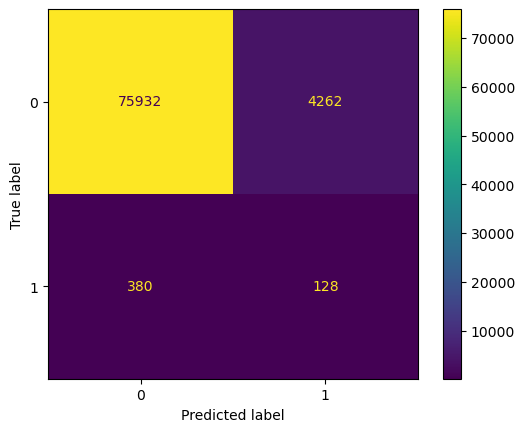

In [35]:
ConfusionMatrixDisplay.from_estimator(gs, X_test['comments_clean'], y_test);

#### Still low recall score - lots of false positives

In [36]:
recall_score(y_test, gs.predict(X_test['comments_clean']) )

0.25196850393700787

In [38]:
f1_score(y_test, gs.predict(X_test['comments_clean']) )

0.052266231114740706

In [39]:
prob_df = pd.DataFrame(gs.predict_proba(gs.best_estimator_.named_steps.tf.get_feature_names_out() ), columns = ['above_5th_percentile', 'below_5th_percentile'])
prob_df

,above_5th_percentile,below_5th_percentile
0,0.771921,0.228079
1,0.510649,0.489351
2,0.275597,0.724403
3,0.243880,0.756120
4,0.274937,0.725063
...,...,...
29995,0.179158,0.820842
29996,0.471676,0.528324
29997,0.609453,0.390547
29998,0.407728,0.592272


In [40]:
feature_words = pd.DataFrame( gs.best_estimator_.named_steps.tf.get_feature_names_out(), columns = ['features'])
feature_words

,features
0,00
1,00 pm
2,000
3,02h
4,02h du
...,...
29995,했지만 깨끗하였습니다 캐비닛과
29996,호스트는
29997,화장실
29998,화장실 욕실이


In [41]:
word_probs = feature_words.join(prob_df)
word_probs.sort_values('above_5th_percentile', ascending = False).head(20)

,features,above_5th_percentile,below_5th_percentile
20214,place clean comfortable,0.999187,0.000813
5680,comfortable,0.998710,0.001290
15883,location perfect,0.998615,0.001385
26375,super clean comfortable,0.997984,0.002016
16355,loved stay,0.997896,0.002104
20470,place perfect,0.997842,0.002158
19776,perfect,0.997672,0.002328
25680,stay perfect,0.997487,0.002513
20209,place clean,0.997409,0.002591
26430,super responsive,0.996846,0.003154


#### Still including Jasmine because using English only stop words in the model

In [42]:
word_probs.sort_values('below_5th_percentile', ascending = False).head(20)

,features,above_5th_percentile,below_5th_percentile
14045,jasmine,7.600454e-09,1.000000
14051,jasmine great,2.616849e-06,0.999997
14054,jasmine place,3.873161e-06,0.999996
29717,yousong,6.043139e-06,0.999994
14052,jasmine house,2.113706e-05,0.999979
7294,dee,3.126542e-05,0.999969
14057,jasmine responsive,3.641121e-05,0.999964
4824,christmas jasmine,4.153196e-05,0.999958
27192,todd,4.887241e-05,0.999951
3516,br jasmine,5.193904e-05,0.999948
